In [2]:
# !pip install pandas

   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   ------------ --------------------------- 3.4/10.8 MB 20.2 MB/s eta 0:00:01
   -------------------- ------------------- 5.5/10.8 MB 17.7 MB/s eta 0:00:01
   --------------------------------- ------ 8.9/10.8 MB 15.0 MB/s eta 0:00:01
   ---------------------------------------- 10.8/10.8 MB 15.0 MB/s eta 0:00:00


In [4]:
# !pip install mediapipe opencv-python scikit-learn==0.24.1

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/6.9 MB ? eta -:--:--
   ------------------ --------------------- 3.1/6.9 MB 16.9 MB/s eta 0:00:01
   ---------------------------------------- 6.9/6.9 MB 17.0 MB/s eta 0:00:00
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


In [1]:
import mediapipe as mp # Import mediapipe
import cv2 # Import opencv
import csv
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 
import sklearn
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score # Accuracy metrics 
import pickle 
import time
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

In [3]:
import numpy as np
print(np.__version__)

1.24.4


In [4]:
print(mp.__version__)

0.10.10


In [5]:
import sklearn
print(sklearn.__version__)

0.24.1


In [6]:
with open("C:/Users/USER/Downloads/body_language.pkl", 'rb') as f:
    model = pickle.load(f)

In [7]:
model.predict[0]

TypeError: 'function' object is not subscriptable

In [8]:
def calculate_angle(a,b):
    a = np.array(a)
    b = np.array(b)
    
    radians = np.arctan2(b[1]-a[1], b[0]-a[0])
    angle = np.abs(radians*180.0/np.pi)

    return angle 

In [9]:
# 선택한 이미지를 불러옵니다
overlay_image = cv2.imread('./background.png', cv2.IMREAD_UNCHANGED)  # 이미지 파일 경로 지정

# 눈 좌표 범위
LEFT_EYE_INDEXES = [33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7]
RIGHT_EYE_INDEXES = [362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382]

LEFT_IRIS_INDEXES = [469, 470, 471, 472]
RIGHT_IRIS_INDEXES = [474, 475, 476, 477]

cap = cv2.VideoCapture(0)

def get_eye_region(landmarks, indexes, scale_x, scale_y):
    # 랜드마크 좌표를 사용하여 눈 영역 추출
    points = []
    for idx in indexes:
        x = int(landmarks[idx].x * frame.shape[1] * scale_x)
        y = int(landmarks[idx].y * frame.shape[0] * scale_y)
        points.append([x, y])
    return np.array(points, dtype=np.int32)

def get_iris_center(landmarks, iris_indexes, scale_x, scale_y):
    # 홍채 중심 좌표 계산
    iris_points = np.array([[landmarks[idx].x * frame.shape[1] * scale_x, landmarks[idx].y * frame.shape[0] * scale_y] for idx in iris_indexes])
    iris_center = np.mean(iris_points, axis=0).astype(int)
    val_iris_center = np.mean(iris_points, axis=0)
    return iris_center, val_iris_center

# Curl counter variables
warning = False
pose_bad_count = 0
pose_good_count = 0
eye_bad_count = 0
eye_good_count = 0

# stretch_count = 0
# stand_count = 0
start = time.gmtime(time.time())  # 시작 시간 저장

pose_frame_counter = 0
eye_frame_counter = 0
total_pose_bad_count = 0
total_pose_good_count = 0
avg_pose_bad_count_per_second = 0
avg_pose_good_count_per_second = 0
total_eye_bad_count = 0
total_eye_good_count = 0
avg_eye_bad_count_per_second = 0
avg_eye_good_count_per_second = 0

face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)
# # Initiate holistic model
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

left_iris_list = []
right_iris_list = []
left_uclid_distance = []
right_uclid_distance = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # 거울모드
    frame = cv2.flip(frame, 1)

    # 원본 크기 저장
    original_height, original_width = frame.shape[:2]

    # 프레임 리사이즈
    resize_frame = cv2.resize(frame, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)

    # 리사이즈된 이미지의 크기
    resized_height, resized_width = resize_frame.shape[:2]

    # 리사이즈 비율 계산
    scale_x = resized_width / original_width
    scale_y = resized_height / original_height

    # Recolor Feed
    image = cv2.cvtColor(resize_frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False        
    
    # Make Detections
    results = holistic.process(image)
    
    # Recolor image back to BGR for rendering
    image.flags.writeable = True   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # 1. Draw face landmarks
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
    #                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
    #                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                          )
    
    # 2. Right hand
    # mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
    #                          mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
    #                          mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
    #                          )

    # 3. Left Hand
    # mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
    #                          mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
    #                          mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
    #                          )

    # 4. Pose Detections
    # mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
    #                          mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
    #                          mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
    #                          )
    
    # 얼굴 랜드마크 그리기 및 눈동자 추출
    face_result = face_mesh.process(image)

    try:
        landmarks = results.pose_landmarks.landmark
        # Get coordinates
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
        
        # # Calculate angle
        angle = calculate_angle(left_shoulder, right_shoulder)
        # Curl counter logic
        temp_pose = ''
        if angle < 176:
            pose_bad_count += 1
            total_pose_bad_count += 1
            temp_pose = 'BAD' 
        elif angle >= 176:
            pose_good_count += 1
            total_pose_good_count += 1
            temp_pose = 'GOOD'
        pose_frame_counter += 1

        if pose_frame_counter >= 30:
            avg_pose_bad_count_per_second = round(total_pose_bad_count / 30, 8)
            avg_pose_good_count_per_second = round(total_pose_good_count / 30, 8)

            # 변수 리셋
            pose_frame_counter = 0
            total_pose_bad_count = 0
            total_pose_good_count = 0
            


        # Extract Pose landmarks
        pose = results.pose_landmarks.landmark
        pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
        
        # Extract Face landmarks
        face = results.face_landmarks.landmark
        face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())
        
        # Concate rows
        row = pose_row+face_row
        
        # Make Detections
        X = np.array([row])

        body_language_class = model.predict(X)[0]
        body_language_prob = model.predict_proba(X)[0]
        # Get status box
        cv2.putText(image, f'angle : {angle}', (10,25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, f'good_pose_count : {avg_pose_good_count_per_second}', (10,65), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, f'bad_pose_count : {avg_pose_bad_count_per_second}', (10,105), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, f'Pose is good?: {temp_pose}', (10, 235), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 1, cv2.LINE_AA)
        
        #Time
        now = time.gmtime(time.time())
        
        cv2.putText(image, 'Time', 
                    (440,25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        seconds = 0
        minute = 0
        if now.tm_sec < start.tm_sec:
            seconds = 60 - start.tm_sec + now.tm_sec
        else:
            seconds = abs(now.tm_sec - start.tm_sec)

        cv2.putText(image, str(minute) +' : '+ str(seconds),
                    (500,25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        
        # 얼굴 랜드마크가 있으면 처리
        if face_result.multi_face_landmarks:
            for face_landmark in face_result.multi_face_landmarks:
                
                # 왼쪽 눈과 오른쪽 눈 영역 추출 (크기 비율 적용)
                left_eye = get_eye_region(face_landmark.landmark, LEFT_EYE_INDEXES, scale_x, scale_y)
                right_eye = get_eye_region(face_landmark.landmark, RIGHT_EYE_INDEXES, scale_x, scale_y)

                # 눈 영역에 다각형 그리기
                # cv2.polylines(image, [left_eye], isClosed=True, color=(0, 255, 0), thickness=1)
                # cv2.polylines(image, [right_eye], isClosed=True, color=(0, 255, 0), thickness=1)

                # 왼쪽 및 오른쪽 홍채 중심 추출
                left_iris_center, val_left_iris_center = get_iris_center(face_landmark.landmark, LEFT_IRIS_INDEXES, scale_x, scale_y)
                right_iris_center, val_right_iris_center = get_iris_center(face_landmark.landmark, RIGHT_IRIS_INDEXES, scale_x, scale_y)
                left_iris_list.append(val_left_iris_center)
                right_iris_list.append(val_right_iris_center)
                left_uclid_distance.append(np.linalg.norm(left_eye - val_left_iris_center))
                right_uclid_distance.append(np.linalg.norm(right_eye - val_right_iris_center))
                # 홍채 중심에 원 그리기
                # cv2.circle(image, tuple(left_iris_center), 3, (255, 0, 0), -1)
                # cv2.circle(image, tuple(right_iris_center), 3, (255, 0, 0), -1)

                # 왼쪽 눈동자 중심 계산
                left_eye_center = np.mean(left_eye, axis=0)
                right_eye_center = np.mean(right_eye, axis=0)

                # 눈동자 중심에 원 그리기
                # cv2.circle(image, tuple(left_eye_center), 3, (0, 255, 0), -1)
                # cv2.circle(image, tuple(right_eye_center), 3, (0, 255, 0), -1)

                left_eye_direction = ''
                right_eye_direction = ''

                if -3 < left_eye_center[0] - val_left_iris_center[0] <= 2 and 0.3 <= left_eye_center[1] - val_left_iris_center[1] <= 1.7:
                    left_eye_direction = 'center'
                elif abs(val_left_iris_center[0] - left_eye_center[0]) <= 3 and  left_eye_center[1] - val_left_iris_center[1] > 1.7:
                    left_eye_direction = 'top'
                elif abs(val_left_iris_center[0] - left_eye_center[0]) <= 3 and  left_eye_center[1] - val_left_iris_center[1] < 0.3:
                    left_eye_direction = 'bottom'
                elif left_eye_center[0] - val_left_iris_center[0] > 2:
                    left_eye_direction = 'left'
                elif left_eye_center[0] - val_left_iris_center[0] < -3:
                    left_eye_direction = 'right'

                if  -2.5 <= right_eye_center[0] - val_right_iris_center[0] <= 2.5 and 0.3 <= right_eye_center[1] - val_right_iris_center[1] <= 1.7:
                    right_eye_direction = 'center'
                elif abs(val_right_iris_center[0] - right_eye_center[0]) <= 3 and right_eye_center[1] - val_right_iris_center[1] > 1.7:
                    right_eye_direction = 'top'
                elif abs(val_right_iris_center[0] - right_eye_center[0]) <= 3 and right_eye_center[1] - val_right_iris_center[1] < 0.3:
                    right_eye_direction = 'bottom'
                elif right_eye_center[0] - val_right_iris_center[0] > 2.5:
                    right_eye_direction = 'left'
                elif right_eye_center[0] - val_right_iris_center[0] < -2.5:
                    right_eye_direction = 'right'

                eye_temp = ''
                
                if left_eye_direction == right_eye_direction and left_eye_direction != 'center':
                    eye_bad_count += 1
                    total_eye_bad_count += 1
                    # good_count = 0
                    eye_temp='BAD'
                else:
                    eye_good_count += 1
                    total_eye_good_count += 1
                    eye_temp='GOOD'

                eye_frame_counter += 1

                if eye_frame_counter >= 30:
                    avg_eye_bad_count_per_second = round(total_eye_bad_count / 30, 8)
                    avg_eye_good_count_per_second = round(total_eye_good_count / 30, 8)

                    # 변수 리셋
                    eye_frame_counter = 0
                    total_eye_bad_count = 0
                    total_eye_good_count = 0
                

                # 홍채 좌표 출력
                cv2.putText(image, f'L Iris: {val_left_iris_center}', (440, 65), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, f'R Iris: {val_right_iris_center}', (440, 145), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1, cv2.LINE_AA)
                # 눈동자 중심 좌표 출력
                cv2.putText(image, f'L eye: {left_eye_center}', (440, 105), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, f'R eye: {right_eye_center}', (440, 190), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1, cv2.LINE_AA)
                # 눈 방향
                cv2.putText(image, f'good eye count: {avg_eye_good_count_per_second}', (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, f'bad eye count: {avg_eye_bad_count_per_second}', (10, 145), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1, cv2.LINE_AA)
                # 시선 벗어났는지
                cv2.putText(image, f'Eye is good?: {eye_temp}', (620, 235), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 1, cv2.LINE_AA)
                # cv2.putText(image, f'L eye direction: {avg_eye_bad_count_per_second}', (10, 145), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1, cv2.LINE_AA)
                # cv2.putText(image, f'R eye direction: {avg_eye_good_count_per_second}', (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1, cv2.LINE_AA)

    except Exception as e:
        print(e)

    # 원하는 이미지 크기와 위치 설정
    overlay_width = 600  # 이미지의 가로 크기
    overlay_height = 600  # 이미지의 세로 크기
    overlay_position = (180, 120)  # 이미지가 배치될 왼쪽 위 좌표 (x, y)

    # 선택한 이미지를 리사이즈
    overlay_resized = cv2.resize(overlay_image, (overlay_width, overlay_height))

    # ROI(Region of Interest)를 설정하여 이미지를 해당 위치에 삽입
    x, y = overlay_position
    roi = image[y:y+overlay_height, x:x+overlay_width]
    
    # 알파 채널 분리
    if overlay_resized.shape[2] == 4:  # 이미지가 알파 채널을 가지고 있는지 확인
        overlay_img = overlay_resized[:, :, :3]  # RGB 채널
        mask = overlay_resized[:, :, 3]  # 알파 채널

        # 알파 채널을 [0, 1] 범위로 정규화
        mask = mask / 255.0

        # 불투명도 조정 (원하는 값으로 alpha 설정)
        alpha = 0.4  # 불투명도: 1.0은 완전 불투명, 0.0은 완전 투명

        # 배경에 원래 프레임의 해당 부분 복사
        background = (1.0 - mask * alpha)[:, :, np.newaxis] * roi
        # 전경에 overlay 이미지 복사
        foreground = (mask * alpha)[:, :, np.newaxis] * overlay_img

        # 배경과 전경을 더해 합성
        blended = background + foreground

        # 합성된 이미지를 원본 프레임에 적용
        image[y:y+overlay_height, x:x+overlay_width] = blended

    # 결과 이미지 출력
    cv2.imshow('Camera Feed with Transparent Image Overlay', image)

    # q를 눌러서 종료
    if cv2.waitKey(10) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()

In [10]:
print(f'l_iris : {left_iris_list}')
print()
print(f'r_iris : {right_iris_list}')
print()
print(f'l_uclid : {left_uclid_distance}')
print()
print(f'r_uclid : {right_uclid_distance}')

l_iris : [array([411.95379496, 402.39781737]), array([421.56122446, 401.89169526]), array([426.85820103, 402.07101703]), array([428.49673748, 401.72003388]), array([429.05254126, 401.35982394]), array([427.79300451, 401.69792175]), array([418.35325241, 403.07488203]), array([418.88400793, 402.62611628]), array([420.76547384, 404.87548113]), array([421.01104975, 404.76055384]), array([420.80951214, 405.71440101]), array([421.53936625, 405.73449612]), array([412.45485306, 399.95087028]), array([399.61687088, 401.71094656]), array([397.226758  , 403.46407056]), array([392.15631723, 405.3488481 ]), array([402.27703571, 412.77843833]), array([414.12963867, 413.81772995]), array([412.28288412, 413.39160204]), array([409.9793601, 416.2470603]), array([408.11277866, 416.258744  ]), array([409.42398548, 415.85201383]), array([406.60895348, 412.96468019]), array([406.84390783, 412.68448591]), array([406.76601648, 412.04792261]), array([410.30859232, 407.40384936]), array([412.87538052, 405.53042

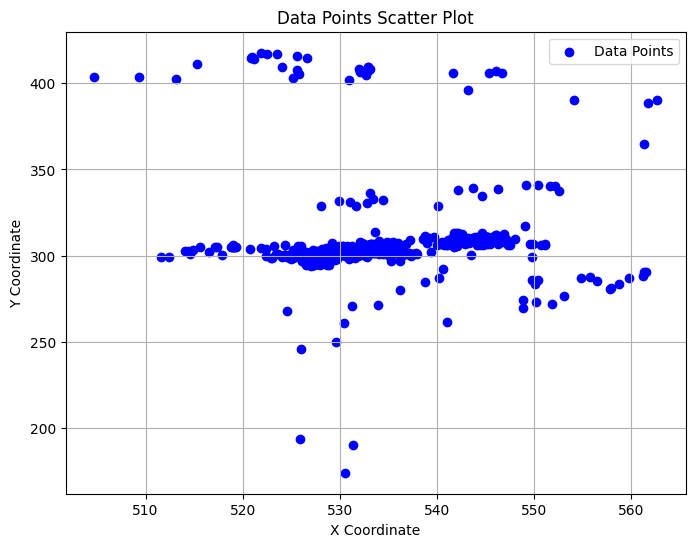

In [15]:
left_data = np.array(left_iris_list)
right_data = np.array(right_iris_list)
# 데이터에서 x와 y 좌표 분리
x = right_data[:, 0]
y = right_data[:, 1]

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='b', label='Data Points')  # scatter plot으로 점만 표시

# 그래프 제목과 라벨 추가
plt.title('Data Points Scatter Plot')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# 범례 추가
plt.legend()

# 그래프 표시
plt.grid(True)
plt.show()

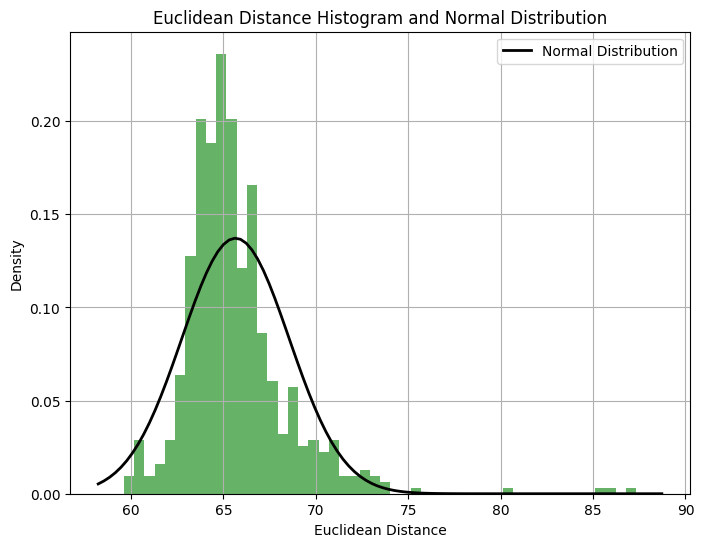

In [28]:
# 데이터를 numpy 배열로 변환
data = np.array(right_uclid_distance)

# 평균과 표준편차 계산
mean = np.mean(data)
std_dev = np.std(data)

# 히스토그램 그리기
plt.figure(figsize=(8, 6))
count, bins, ignored = plt.hist(data, bins=50, density=True, alpha=0.6, color='g')

# 정규분포 곡선 계산
xmin, xmax = plt.xlim()  # 히스토그램의 범위 가져오기
x = np.linspace(xmin, xmax, 100)  # xmin에서 xmax까지 100개의 점 생성
p = norm.pdf(x, mean, std_dev)  # 평균과 표준편차를 기반으로 정규분포 계산

# 정규분포 곡선 그리기
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

# 그래프 제목과 라벨 추가
plt.title('Euclidean Distance Histogram and Normal Distribution')
plt.xlabel('Euclidean Distance')
plt.ylabel('Density')

# 범례 추가
plt.legend()

# 그래프 표시
plt.grid(True)
plt.show()

In [ ]:
# 25% 나눠서 얼마나 집중을 잘했는지 못했는지